In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

sample_submission.csv
test.csv
train.csv



### Target encoding with smoothing
min_samples_leaf define a threshold where prior and target mean (for a given category value) have the same weight. Below the threshold prior becomes more important and above mean becomes more important.

How weight behaves against value counts is controlled by smoothing parameter

In [2]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

### Testing with ps_car_11_cat

In [3]:
# reading data
trn_df = pd.read_csv("../input/train.csv", index_col=0)
sub_df = pd.read_csv("../input/test.csv", index_col=0)

# Target encode ps_car_11_cat
trn, sub = target_encode(trn_df["ps_car_11_cat"], 
                         sub_df["ps_car_11_cat"], 
                         target=trn_df.target, 
                         min_samples_leaf=100,
                         smoothing=10,
                         noise_level=0.01)
trn.head(10)

id
7     0.038917
9     0.023708
13    0.030953
16    0.044688
17    0.026341
19    0.045348
20    0.022527
22    0.030300
26    0.033820
28    0.044770
Name: ps_car_11_cat_mean, dtype: float64

### Scatter plot of category values vs target encoding
We see that the category values are not ordered


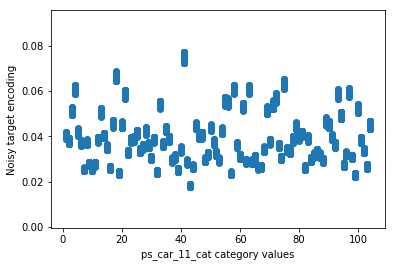

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(trn_df["ps_car_11_cat"], trn)
plt.xlabel("ps_car_11_cat category values")
plt.ylabel("Noisy target encoding")

### Check AUC metric improvement after noisy encoding over 5 folds

In [5]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
f_cats = [f for f in trn_df.columns if "_cat" in f]
print("%20s   %20s | %20s" % ("", "Raw Categories", "Encoded Categories"))
for f in f_cats:
    print("%-20s : " % f, end="")
    e_scores = []
    f_scores = []
    for trn_idx, val_idx in folds.split(trn_df.values, trn_df.target.values):
        trn_f, trn_tgt = trn_df[f].iloc[trn_idx], trn_df.target.iloc[trn_idx]
        val_f, val_tgt = trn_df[f].iloc[trn_idx], trn_df.target.iloc[trn_idx]
        trn_tf, val_tf = target_encode(trn_series=trn_f, 
                                       tst_series=val_f, 
                                       target=trn_tgt, 
                                       min_samples_leaf=100, 
                                       smoothing=20,
                                       noise_level=0.01)
        f_scores.append(max(roc_auc_score(val_tgt, val_f), 1 - roc_auc_score(val_tgt, val_f)))
        e_scores.append(roc_auc_score(val_tgt, val_tf))
    print(" %.6f + %.6f | %6f + %.6f" 
          % (np.mean(f_scores), np.std(f_scores), np.mean(e_scores), np.std(e_scores)))

                             Raw Categories |   Encoded Categories
ps_ind_02_cat        :  0.506205 + 0.000645 | 0.508456 + 0.001132
ps_ind_04_cat        :  0.512617 + 0.000721 | 0.514476 + 0.001560
ps_ind_05_cat        :  0.520250 + 0.000760 | 0.534369 + 0.001934
ps_car_01_cat        :  0.528912 + 0.000736 | 0.552015 + 0.001517
ps_car_02_cat        :  0.531614 + 0.000786 | 0.531642 + 0.001340
ps_car_03_cat        :  0.539652 + 0.000782 | 0.539038 + 0.001555
ps_car_04_cat        :  0.536473 + 0.000532 | 0.536465 + 0.001234
ps_car_05_cat        :  0.530585 + 0.000432 | 0.530795 + 0.000676
ps_car_06_cat        :  0.515692 + 0.000817 | 0.542923 + 0.000841
ps_car_07_cat        :  0.522623 + 0.000671 | 0.522535 + 0.001586
ps_car_08_cat        :  0.520287 + 0.000602 | 0.521506 + 0.002040
ps_car_09_cat        :  0.504888 + 0.000700 | 0.525121 + 0.001698
ps_car_10_cat        :  0.500254 + 0.000058 | 0.501058 + 0.001909
ps_car_11_cat        :  0.512414 + 0.001029 | 0.574298 + 0.000581
